In [21]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data1 = scipy.io.loadmat("D:\Research Dr. Power\BCI_IV_2a\BCI_IV_2a\A01E.mat")

In [6]:
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [6]:
raw = np.squeeze(data1['data'])

In [16]:
data1['data'][0][4][0][0][0].T.shape

(25, 96735)

In [20]:
data1['data'][0][4][0][0][0][6]

array([ -8.83789062,  -7.421875  ,  -7.95898438, -10.49804688,
       -12.74414062, -13.81835938,  -2.78320312,  -4.24804688,
        -4.39453125,  -6.20117188, -10.30273438, -12.109375  ,
        -7.8125    ,  -3.41796875,  -2.97851562,  -4.00390625,
        -6.78710938,  -7.47070312,  -3.90625   ,  -2.78320312,
        -4.4921875 ,  -6.49414062,  19.04296875,   6.8359375 ,
       -12.6953125 ])

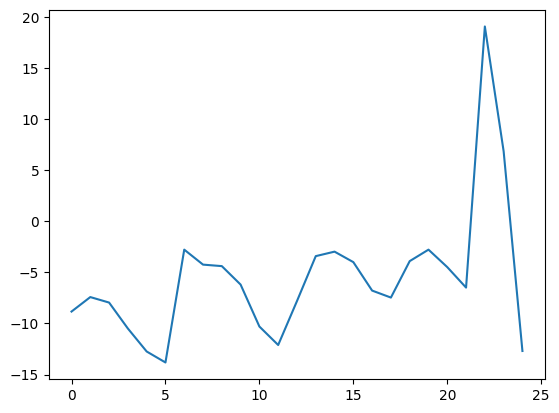

In [22]:
plt.plot(data1['data'][0][4][0][0][0][6])

In [30]:
a = [data1['data'][0][4][0][0][1][6] + 2*250, data1['data'][0][4][0][0][1][6] + 6*250]
print(a)

[array([12660]), array([13660])]


In [34]:
s1 = data1['data'][0][4][0][0][0].T

In [40]:
with_artifact = s1[:, int(a[0]):int(a[1])]

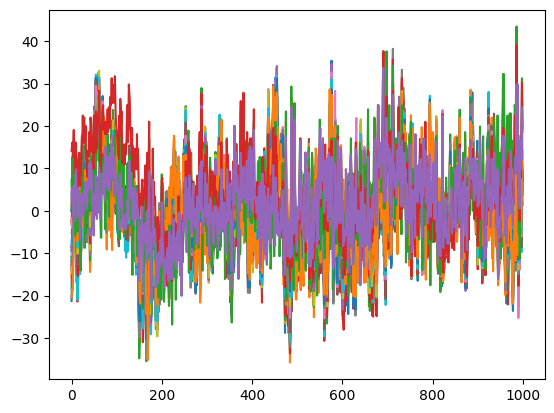

In [43]:
for i in range(25):
    plt.plot(with_artifact[i])
    

In [10]:
raw[0]

(1,)

In [48]:
# Imports
import glob
from scipy.io import loadmat,savemat
from scipy.signal import butter, sosfiltfilt
import os

# Variables we will output
DATA = []           
subj_labels = []    
class_labels = [] 

## Pre-Processing ##
# channel indices for EEG rather than EOG
eeg_channels = np.arange(22)

# Bandpass noise digital filter
filter_order = 6
fs = 250
cutoff_freqs = np.array([3,40])
butter_sos = butter(N = filter_order, 
                    Wn = cutoff_freqs, 
                    btype = 'bandpass',
                    analog = False,
                    output = 'sos',
                    fs = fs)

# EDIT THIS LINE: Insert directory where your BCI IV 2a mat files are
os.chdir(r'D:\Research Dr. Power\BCI_IV_2a\BCI_IV_2a')

# Go through all files
for filename in glob.glob("*.mat"):
    print('Retrieving data from '+filename+'...')
    
    # Get data
    subj_name = filename[:3]
    raw = loadmat(filename)
    raw = np.squeeze(raw['data'])
    
    # Go through the subjects sessions of interest and build dataset
    for i in range(np.size(raw)-6,np.size(raw)):
        
        # Convert from a MATLAB struct to something readable in python
        X = raw[i][0][0][0].T                           # Session data
        triggers = np.squeeze(raw[i][0][0][1])          # EEG sample aligned with the beep
        y = np.squeeze(raw[i][0][0][2])                 # class labels
        artifact = np.squeeze(raw[i][0][0][5]) == True  # Array of artifact presence evaluated by experts
        
        # Add our 2 second offset to the trigger sample get data 2s after beep
        mi_offset = int(2 * fs)
        triggers += mi_offset
        mi_duration = int(4*fs) # 6s - 2s

        # Go through each run of each session
        for i in range(len(y)):
            # Only add artifact-free trials
            if not artifact[i]:
                
                # Remove unwanted frequencies from the signal using 0-phase filtering
                X_filtered = sosfiltfilt(butter_sos, X, axis = -1)
                
                # Get the event EEG data
                event_data = X_filtered[eeg_channels,triggers[i]:triggers[i] + mi_duration]
                
                # Add data to dataset, and subject/class labels to our vectors of interest
                if np.size(DATA) == 0:
                    DATA = event_data
                    subj_labels = [subj_name]
                    class_labels = [y[i]]
                else:
                    DATA = np.concatenate((DATA,event_data), axis = 1)
                    subj_labels = np.concatenate((subj_labels,[subj_name]))
                    class_labels = np.concatenate((class_labels,[y[i]]))

# Reshape DATA to a reshaped 3D matrix (number_trials x n_channels x trial_len)
M_res = np.reshape(DATA.T,(mi_duration,int(DATA.shape[1]/mi_duration),DATA.shape[0]), order = 'F')
M_res = np.moveaxis(M_res,1,0)
M_res = np.moveaxis(M_res,2,1)

# Save our new .mat file
dataset_dict = {'M_res' : M_res,
'subj_labels' : subj_labels,
'class_labels' : class_labels}

savemat('BCI_IV_2a.mat',dataset_dict)


Retrieving data from A01E.mat...
Retrieving data from A01T.mat...
Retrieving data from A02E.mat...
Retrieving data from A02T.mat...
Retrieving data from A03E.mat...
Retrieving data from A03T.mat...
Retrieving data from A04E.mat...
Retrieving data from A04T.mat...
Retrieving data from A05E.mat...
Retrieving data from A05T.mat...
Retrieving data from A06E.mat...
Retrieving data from A06T.mat...
Retrieving data from A07E.mat...
Retrieving data from A07T.mat...
Retrieving data from A08E.mat...
Retrieving data from A08T.mat...
Retrieving data from A09E.mat...
Retrieving data from A09T.mat...


In [68]:
dataset_dict['subj_labels'][553]

'A01'